**Задача**: проанализировать информацию о числе заказов за 3 месяца с разрешением по неделям. *Построить (если это возможно) прогноз продаж на следующие 3 месяца*, с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%.
<hr>

**Импортируем необходимые библиотеки:**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import stats
import statsmodels.api as sm
import numpy as np
import datetime

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (15, 5)

**Загружаем данные:**

In [2]:
number_of_orders = pd.read_csv("https://stepik.org/media/attachments/lesson/426638/test2_completed.csv")

**Меняем названия колонок для удобства, приводим колонку Date к формату дат и создаём колонку с timestamp:**

In [3]:
number_of_orders.rename(columns={"Дата": "Date", "Число заказов": "Orders"}, inplace=True)

In [4]:
number_of_orders["Date"] = pd.to_datetime(number_of_orders["Date"])
number_of_orders["Timestamp"] = number_of_orders["Date"].values.astype(np.int64) // 10 ** 9
number_of_orders['Date'] = number_of_orders['Date'].dt.date

**Построим диаграмму рассеивания, чтобы составить общее впечатление о характере взамосвязи двух наших переменных:**

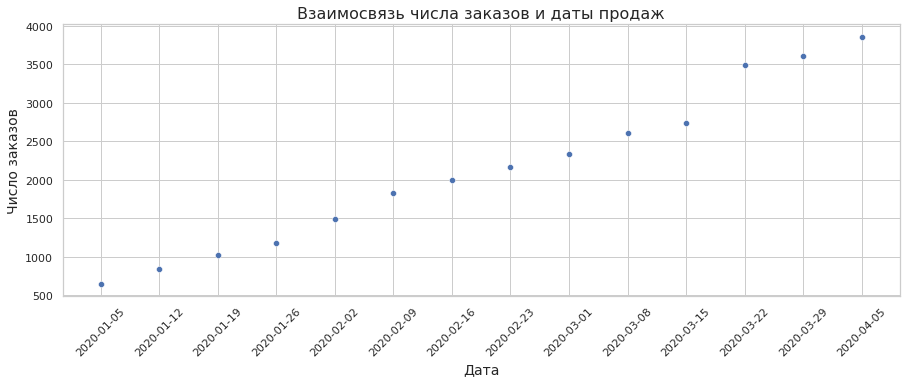

In [5]:
sns.scatterplot(x='Timestamp', y='Orders', data=number_of_orders)
plt.title("Взаимосвязь числа заказов и даты продаж", size=16)
plt.xlabel("Дата", size=14)
plt.xticks(ticks=number_of_orders['Timestamp'], labels=number_of_orders['Date'], rotation=45)
plt.ylabel("Число заказов", size=14);

**Как мы можем видеть, взимосвязь нашей ЗП и НП является линейной и положительной.**

**Рассчитаем коэффициент корреляции и p-значение.**

In [6]:
st.pearsonr(number_of_orders["Timestamp"], number_of_orders["Orders"])

(0.9912385193764018, 6.408985072064745e-12)

**Мы получили высокий уровень корреляции, а также статзначимое p-значение**

**Посмотрим на распределение остатков**

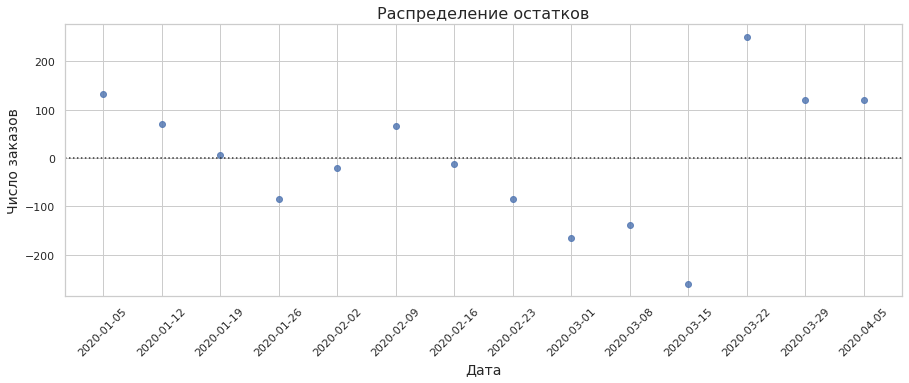

In [7]:
sns.residplot(x=number_of_orders["Timestamp"], y=number_of_orders["Orders"])
plt.xticks(ticks=number_of_orders['Timestamp'], labels=number_of_orders['Date'], rotation=45)
plt.title('Распределение остатков', size=16)
plt.xlabel("Дата", size=14)
plt.ylabel("Число заказов", size=14);

**В целом остатки распределены равномерно.**

**Применим регрессионный анализ:**

In [8]:
X = sm.add_constant(number_of_orders["Timestamp"])  
model = sm.OLS(number_of_orders["Orders"], X).fit() 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Orders   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     675.8
Date:                Fri, 16 Jul 2021   Prob (F-statistic):           6.41e-12
Time:                        15:32:38   Log-Likelihood:                -88.326
No. Observations:                  14   AIC:                             180.7
Df Residuals:                      12   BIC:                             181.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.454e+05   2.49e+04    -25.911      0.0

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


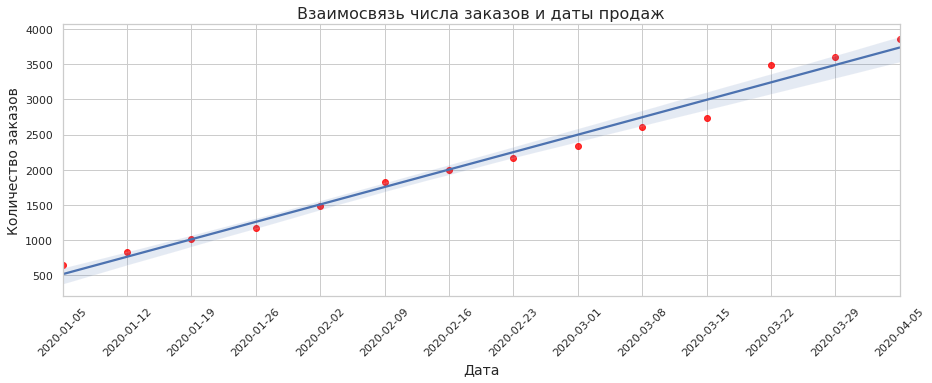

In [9]:
sns.regplot(x='Timestamp', y='Orders', data=number_of_orders, scatter_kws={'color': 'red'})
plt.title('Взаимосвязь числа заказов и даты продаж', size=16)
plt.xlabel('Дата', size=14)
plt.xticks(ticks=number_of_orders['Timestamp'], labels=number_of_orders['Date'], rotation=45)
plt.ylabel('Количество заказов', size=14);

**Создадим массив со значениями НП для предсказания значений ЗП на последующие 3 месяца по неделям:**

In [10]:
new_dates = ['2020-04-12', '2020-04-19', '2020-04-26', '2020-05-03', '2020-05-10', '2020-05-17', '2020-05-24', '2020-05-31',
            '2020-06-07', '2020-06-14', '2020-06-21', '2020-06-28', '2020-07-05']

In [11]:
new_dates_timestamp = [int(datetime.datetime.strptime(i, '%Y-%m-%d').strftime("%s")) for i in new_dates]

In [12]:
new_dates = np.array(new_dates)

In [13]:
new_dates_with_constant = sm.add_constant(new_dates_timestamp) 

**Предсказываем значения количества заказов на последующие 3 месяца:**

In [14]:
orders_predicted = model.predict(new_dates_with_constant)

**Получившиеся значения:**

In [15]:
print(orders_predicted)

[3980.92140241 4228.44667713 4475.97195186 4723.49722658 4971.02250131
 5218.54777603 5466.07305076 5713.59832548 5961.12360021 6208.64887493
 6456.17414966 6703.69942439 6951.22469911]


In [16]:
number_of_orders_predicted = pd.DataFrame({'Date':new_dates,'Orders': orders_predicted, 'Timestamp': new_dates_timestamp})

In [17]:
number_of_orders_predicted["Orders"] = round(number_of_orders_predicted["Orders"]).astype(int)

In [18]:
number_of_orders_old_new = pd.concat([number_of_orders, number_of_orders_predicted]).reset_index(drop=True)

In [19]:
number_of_orders_old_new

,Date,Orders,Timestamp
0,2020-01-05,650,1578182400
1,2020-01-12,837,1578787200
2,2020-01-19,1020,1579392000
3,2020-01-26,1176,1579996800
4,2020-02-02,1489,1580601600
5,2020-02-09,1823,1581206400
6,2020-02-16,1991,1581811200
7,2020-02-23,2166,1582416000
8,2020-03-01,2334,1583020800
9,2020-03-08,2607,1583625600


In [20]:
number_of_orders_old_new["period"] = number_of_orders_old_new["Timestamp"] > 1586044800

In [21]:
number_of_orders_old_new["period"] = np.where(number_of_orders_old_new["period"] == False, 'known', 'predicted')

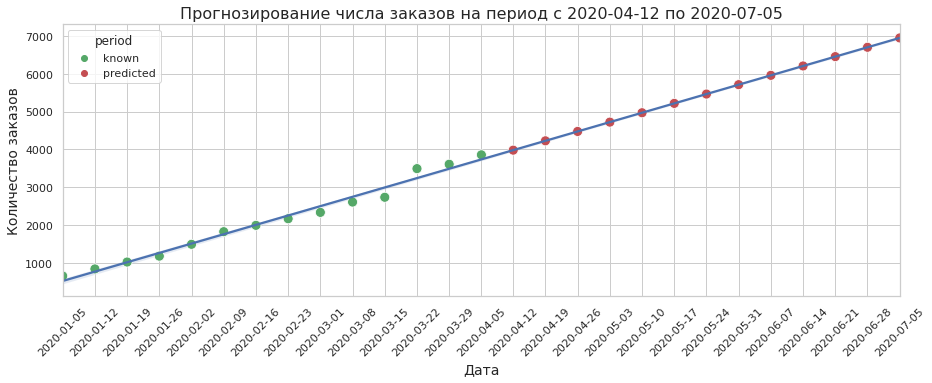

In [22]:
sns.regplot(x='Timestamp', y='Orders', data=number_of_orders_old_new, scatter=False)
sns.scatterplot(x='Timestamp', y='Orders', data=number_of_orders_old_new, hue='period', s=100, palette=['g', 'r'])
plt.xticks(ticks=number_of_orders_old_new['Timestamp'], labels=number_of_orders_old_new['Date'], rotation=45)
plt.title('Прогнозирование числа заказов на период с 2020-04-12 по 2020-07-05', size=16)
plt.xlabel('Дата', size=14)
plt.ylabel('Количество заказов', size=14);

**Вывод:**
>Для предсказания числа заказов на ближайшие три месяца былa применена простая линейная регрессия.
Высокий коэффициент детерминации и равномерное распределение остатков говорят о хорошей предсказательной силе модели. Однако
данных слишком мало для того, чтобы можно было с высокой степенью уверенности говорить о полученных результатах. Данные по 
продажам за три месяца могут не учитывать сезонность, к примеру. 